In [1]:
# %%capture
# !pip install -Uq gdown
# !pip install split-folders
# !pip install natsort
# !pip install torch transformers datasets evaluate pillow==9.2.0

# !pip uninstall timm --y
# !pip -q install --pre timm

In [2]:
## import libraries
import os
import numpy as np
import pandas as pd
import splitfolders
from glob import glob
# from tqdm import tqdm, trange
from tqdm.autonotebook import tqdm, trange
from numba import njit, jit
from natsort import natsorted

import matplotlib.pyplot as plt

#PIL
from PIL import Image, ImageOps

#random
from random import sample

#open cv
import cv2

#sklearn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.preprocessing import LabelBinarizer

#scipy
from scipy import stats #ensemble

#pytorch
import torch
from torch.utils.data import Dataset, Subset
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

#timm
import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

import evaluate

import time

import warnings
warnings.filterwarnings('ignore')

/var/folders/6z/rg8zyzbx1kb_3t3p2f86z5080000gn/T/ipykernel_28173/1262892668.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
## Setup Apple Silicon or CUDA for enhanced training

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'mps'

In [4]:
# import os
# import shutil
# from random import sample

# # Set the base directory to where your 'DROWSINESS_DETECTION' folder is located
# base_directory = 'Data'

# # Define directory names
# drowsy_dir = 'Drowsy'
# non_drowsy_dir = 'Non Drowsy'
# train_dir = 'training'
# test_dir = 'testing'

# # Create test and train directories if they don't exist
# train_drowsy_dir = os.path.join(base_directory, train_dir, drowsy_dir)
# train_non_drowsy_dir = os.path.join(base_directory, train_dir, non_drowsy_dir)
# test_drowsy_dir = os.path.join(base_directory, test_dir, drowsy_dir)
# test_non_drowsy_dir = os.path.join(base_directory, test_dir, non_drowsy_dir)

# os.makedirs(train_drowsy_dir, exist_ok=True)
# os.makedirs(train_non_drowsy_dir, exist_ok=True)
# os.makedirs(test_drowsy_dir, exist_ok=True)
# os.makedirs(test_non_drowsy_dir, exist_ok=True)

# # Function to split data
# def split_data(source_dir, train_class_dir, test_class_dir, split_ratio=0.2):
#     # Get all images in directory
#     all_images = [img for img in os.listdir(source_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
#     # Shuffle and split images
#     test_size = int(len(all_images) * split_ratio)
#     test_images = sample(all_images, test_size)
#     train_images = [img for img in all_images if img not in test_images]
#     # Move images to test and train directories
#     for image in test_images:
#         shutil.move(os.path.join(source_dir, image), os.path.join(test_class_dir, image))
#     for image in train_images:
#         shutil.move(os.path.join(source_dir, image), os.path.join(train_class_dir, image))
#     print(f'Moved {len(test_images)} images to {test_class_dir}')
#     print(f'Moved {len(train_images)} images to {train_class_dir}')

# # Apply the split for both classes
# split_data(os.path.join(base_directory, drowsy_dir), train_drowsy_dir, test_drowsy_dir)
# split_data(os.path.join(base_directory, non_drowsy_dir), train_non_drowsy_dir, test_non_drowsy_dir)


In [5]:
import os

# Set the base directory to where you want to start removing .DS_Store files
base_directory = 'Data'

# Function to remove .DS_Store files
def remove_ds_store_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == '.DS_Store':
                os.remove(os.path.join(root, file))
                print(f'Removed .DS_Store from {root}')

# Call the function
remove_ds_store_files(base_directory)

print("All .DS_Store files have been removed.")


All .DS_Store files have been removed.


In [6]:
# #move validation to train
# lis = glob('./Data/valid/**/*.png')
# for src in tqdm(lis):
#   #destination
#   des = src.replace('valid', 'train')

#   #move
#   os.rename(src, des)


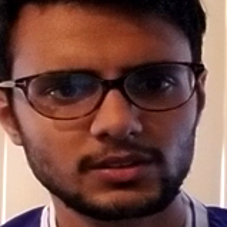

In [7]:
## verify the dataset by opeing one image

paths = glob('./Data/training/**/**')

Image.open(paths[0]).convert("RGB")

In [8]:
## defining image tranformations

img_size_train = 224

img_size_test = 288

transform = {
    "train": transforms.Compose([
        transforms.Resize(size=(img_size_train, img_size_train), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize(size=(img_size_test, img_size_test), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ])
}

In [9]:
## preparing the data

train_path = './Data/training/'

dataset = ImageDataset(train_path, transform=transform["train"])
id2label = natsorted(os.listdir('./Data/Training'))
id2label

['Drowsy', 'Non Drowsy']

In [10]:
y = glob('./Data/training/**/**')
y = natsorted(y)
y = [os.path.basename(os.path.dirname(i)) for i in y]

y[:10]

['Drowsy',
 'Drowsy',
 'Drowsy',
 'Drowsy',
 'Drowsy',
 'Drowsy',
 'Drowsy',
 'Drowsy',
 'Drowsy',
 'Drowsy']

In [11]:
## Check data count
len(paths), len(y)

(33435, 33435)

In [12]:
## Training parameters

model_name = 'resnet18'

num_epochs = 15
criterion = nn.CrossEntropyLoss().to(device)

train_batch_size = 4
eval_batch_size = 4
num_accumulate = 4
num_classes = len(id2label)

## Cross validarion configuration
k_splits = 5
metric = evaluate.load("f1", additional_keys=["accuracy", "precision", "recall", "support"])

In [13]:
all_eval_scores = []

!rm -rf first_model
!mkdir first_model

skf = StratifiedKFold(n_splits=k_splits, shuffle=True)

training_start_time = time.time()

for fold, (train_idx, val_idx) in enumerate(skf.split(dataset, y)):
    
    # display fold number
    print(f"\nFold: {fold+1} / {k_splits}")

    # load model
    model = timm.create_model(model_name=model_name, pretrained=True, num_classes=num_classes).to(device)

    # optimizer and sceduler
    optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-3)
    scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

    # split main dataset into train and val set with kfold
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=True)

    # Reset Model Info
    info = {
        "metric_train": {"f1": [], "accuracy": [], "precision": [], "recall": [], "auc_roc": []},
        "metric_val": {"f1": [], "accuracy": [], "precision": [], "recall": [], "auc_roc": []},
        "train_loss": [],
        "val_loss": [],
        "best_metric_val": -np.inf,
        "confusion_matrix": None,
    }
    count = 0

    # Create a LabelBinarizer object to convert labels to binary class matrix
    lb = LabelBinarizer()

    for epoch in range(num_epochs):
        train_loss_epoch = []
        val_loss_epoch = []
    
        train_preds = []
        train_targets = []
    
        val_preds = []
        val_targets = []
    
        num_updates = epoch * len(train_dataloader)


        # Training loop
        model.train()
        for idx, (X, y) in enumerate(tqdm(train_dataloader)):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)

            loss.backward()

            if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
                optimizer.step()
                scheduler.step_update(num_updates=num_updates)
                optimizer.zero_grad()
            
            train_loss_epoch.append(loss.item())
            train_preds += logits.argmax(-1).detach().tolist()
            train_targets += y.tolist()
        
        optimizer.step()
        scheduler.step(epoch + 1)

        # Evaluation loop

        model.eval()
        with torch.no_grad():
            for (X, y) in tqdm(val_dataloader):
                X, y = X.to(device), y.to(device)
                logits = model(X)
                loss = criterion(logits, y)

                val_loss_epoch.append(loss.item())
                val_preds += logits.argmax(-1).detach().tolist()
                val_targets += y.tolist()


        # Convert labels to binary class matrix
        train_targets_bin = lb.fit_transform(train_targets)
        train_preds_bin = lb.transform(train_preds)

        # Convert labels to binary class matrix
        val_targets_bin = lb.fit_transform(val_targets)
        val_preds_bin = lb.transform(val_preds)
                
        # Compute evaluation metrics
        metric_train = metric.compute(predictions=train_preds, references=train_targets, average="macro")
        metric_val = metric.compute(predictions=val_preds, references=val_targets, average="macro")

        # Calculate metrics for the training set
        precision_train, recall_train, f1_train, support_train = precision_recall_fscore_support(train_targets, train_preds, average='macro')
        acc_train = np.sum(np.array(train_preds) == np.array(train_targets)) / len(train_preds)

        # Calculate metrics for the validation set
        precision_val, recall_val, f1_val, support_val = precision_recall_fscore_support(val_targets, val_preds, average='macro')
        acc_val = np.sum(np.array(val_preds) == np.array(val_targets)) / len(val_preds)

        info["metric_train"]["f1"].append(f1_train)
        info["metric_train"]["precision"].append(precision_train)
        info["metric_train"]["recall"].append(recall_train)
        info["metric_train"]["auc_roc"].append(roc_auc_score(train_targets_bin, train_preds_bin, multi_class='ovo'))
        info["metric_train"]["accuracy"].append(acc_train)

        info["metric_val"]["f1"].append(f1_val)
        info["metric_val"]["precision"].append(precision_val)
        info["metric_val"]["recall"].append(recall_val)
        info["metric_val"]["auc_roc"].append(roc_auc_score(val_targets_bin, val_preds_bin, multi_class='ovo'))
        info["metric_val"]["accuracy"].append(acc_val)
        
        info["train_loss"].append(np.average(train_loss_epoch))
        info["val_loss"].append(np.average(val_loss_epoch))

        cm = confusion_matrix(val_targets, val_preds)
        info["confusion_matrix"] = cm.tolist()

        if metric_val["f1"] > info["best_metric_val"]:
            print("\nNew Best Score!")
            info["best_metric_val"] = metric_val["f1"]
            torch.save(model, f"./first_model/checkpoint_fold{fold}.pt")
            count = 0
        else:
            count += 1
            
        print(info)
        print(f"Fold: {fold} | Epoch: {epoch} | Metric: {metric_val['f1']} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}\n")

    # save all best metric val
    all_eval_scores.append(info["best_metric_val"])

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))



Fold: 1 / 5


  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]


New Best Score!
{'metric_train': {'f1': [0.9860636407646388], 'accuracy': [0.9861298040975026], 'precision': [0.9860262133339565], 'recall': [0.9861016972195664], 'auc_roc': [0.9861016972195664]}, 'metric_val': {'f1': [0.9998497326096619], 'accuracy': [0.9998504561088679], 'precision': [0.9998393316195373], 'recall': [0.9998601789709172], 'auc_roc': [0.9998601789709172]}, 'train_loss': [0.037561127639223715], 'val_loss': [0.00035314744945577956], 'best_metric_val': 0.9998497326096619, 'confusion_matrix': [[3575, 1], [0, 3111]]}
Fold: 0 | Epoch: 0 | Metric: 0.9998497326096619 | Training Loss: 0.037561127639223715 | Validation Loss: 0.00035314744945577956



  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829], 'accuracy': [0.9861298040975026, 0.9973829819051891], 'precision': [0.9860262133339565, 0.9973651403410498], 'recall': [0.9861016972195664, 0.9973755123115012], 'auc_roc': [0.9861016972195664, 0.9973755123115011]}, 'metric_val': {'f1': [0.9998497326096619, 0.9986473658831122], 'accuracy': [0.9998504561088679, 0.9986541049798116], 'precision': [0.9998393316195373, 0.9987225346064319], 'recall': [0.9998601789709172, 0.9985744187651956], 'auc_roc': [0.9998601789709172, 0.9985744187651955]}, 'train_loss': [0.037561127639223715, 0.008265202627338302], 'val_loss': [0.00035314744945577956, 0.0060690373152457325], 'best_metric_val': 0.9998497326096619, 'confusion_matrix': [[3575, 1], [8, 3103]]}
Fold: 0 | Epoch: 1 | Metric: 0.9986473658831122 | Training Loss: 0.008265202627338302 | Validation Loss: 0.0060690373152457325



  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829, 0.9981216184075126], 'accuracy': [0.9861298040975026, 0.9973829819051891, 0.9981307013608494], 'precision': [0.9860262133339565, 0.9973651403410498, 0.9981268291904619], 'recall': [0.9861016972195664, 0.9973755123115012, 0.9981164189482594], 'auc_roc': [0.9861016972195664, 0.9973755123115011, 0.9981164189482593]}, 'metric_val': {'f1': [0.9998497326096619, 0.9986473658831122, 0.9996994463556466], 'accuracy': [0.9998504561088679, 0.9986541049798116, 0.9997009122177359], 'precision': [0.9998393316195373, 0.9987225346064319, 0.9997205142537731], 'recall': [0.9998601789709172, 0.9985744187651956, 0.9996785599485696], 'auc_roc': [0.9998601789709172, 0.9985744187651955, 0.9996785599485696]}, 'train_loss': [0.037561127639223715, 0.008265202627338302, 0.00633247736475105], 'val_loss': [0.00035314744945577956, 0.0060690373152457325, 0.0015814814814750602], 'best_metric_val': 0.9998497326096619, 'confusion_matrix': [[3576, 0], [2, 3

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829, 0.9981216184075126, 0.9992862336160442], 'accuracy': [0.9861298040975026, 0.9973829819051891, 0.9981307013608494, 0.9992896665171228], 'precision': [0.9860262133339565, 0.9973651403410498, 0.9981268291904619, 0.9992784416740073], 'recall': [0.9861016972195664, 0.9973755123115012, 0.9981164189482594, 0.9992940510644234], 'auc_roc': [0.9861016972195664, 0.9973755123115011, 0.9981164189482593, 0.9992940510644234]}, 'metric_val': {'f1': [0.9998497326096619, 0.9986473658831122, 0.9996994463556466, 0.9998497326096619], 'accuracy': [0.9998504561088679, 0.9986541049798116, 0.9997009122177359, 0.9998504561088679], 'precision': [0.9998393316195373, 0.9987225346064319, 0.9997205142537731, 0.9998393316195373], 'recall': [0.9998601789709172, 0.9985744187651956, 0.9996785599485696, 0.9998601789709172], 'auc_roc': [0.9998601789709172, 0.9985744187651955, 0.9996785599485696, 0.9998601789709172]}, 'train_loss': [0.037561127639223715, 0.00

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]


New Best Score!
{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829, 0.9981216184075126, 0.9992862336160442, 0.9987978859187086], 'accuracy': [0.9861298040975026, 0.9973829819051891, 0.9981307013608494, 0.9992896665171228, 0.9988036488709436], 'precision': [0.9860262133339565, 0.9973651403410498, 0.9981268291904619, 0.9992784416740073, 0.9987823682418349], 'recall': [0.9861016972195664, 0.9973755123115012, 0.9981164189482594, 0.9992940510644234, 0.9988135055658587], 'auc_roc': [0.9861016972195664, 0.9973755123115011, 0.9981164189482593, 0.9992940510644234, 0.9988135055658587]}, 'metric_val': {'f1': [0.9998497326096619, 0.9986473658831122, 0.9996994463556466, 0.9998497326096619, 1.0], 'accuracy': [0.9998504561088679, 0.9986541049798116, 0.9997009122177359, 0.9998504561088679, 1.0], 'precision': [0.9998393316195373, 0.9987225346064319, 0.9997205142537731, 0.9998393316195373, 1.0], 'recall': [0.9998601789709172, 0.9985744187651956, 0.9996785599485696, 0.9998601789709172, 1.0]

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829, 0.9981216184075126, 0.9992862336160442, 0.9987978859187086, 0.9985724448989242], 'accuracy': [0.9861298040975026, 0.9973829819051891, 0.9981307013608494, 0.9992896665171228, 0.9988036488709436, 0.9985793330342455], 'precision': [0.9860262133339565, 0.9973651403410498, 0.9981268291904619, 0.9992784416740073, 0.9987823682418349, 0.9985724448989242], 'recall': [0.9861016972195664, 0.9973755123115012, 0.9981164189482594, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242], 'auc_roc': [0.9861016972195664, 0.9973755123115011, 0.9981164189482593, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242]}, 'metric_val': {'f1': [0.9998497326096619, 0.9986473658831122, 0.9996994463556466, 0.9998497326096619, 1.0, 0.9996994463556466], 'accuracy': [0.9998504561088679, 0.9986541049798116, 0.9997009122177359, 0.9998504561088679, 1.0, 0.9997009122177359], 'precision': [0.9998393316195373, 0.9987225346064319, 0.9997205142537731

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829, 0.9981216184075126, 0.9992862336160442, 0.9987978859187086, 0.9985724448989242, 0.999849729472601], 'accuracy': [0.9861298040975026, 0.9973829819051891, 0.9981307013608494, 0.9992896665171228, 0.9988036488709436, 0.9985793330342455, 0.9998504561088679], 'precision': [0.9860262133339565, 0.9973651403410498, 0.9981268291904619, 0.9992784416740073, 0.9987823682418349, 0.9985724448989242, 0.9998549583233414], 'recall': [0.9861016972195664, 0.9973755123115012, 0.9981164189482594, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512], 'auc_roc': [0.9861016972195664, 0.9973755123115011, 0.9981164189482593, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512]}, 'metric_val': {'f1': [0.9998497326096619, 0.9986473658831122, 0.9996994463556466, 0.9998497326096619, 1.0, 0.9996994463556466, 0.999699458945202], 'accuracy': [0.9998504561088679, 0.9986541049798116, 0.9997009122177359, 

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829, 0.9981216184075126, 0.9992862336160442, 0.9987978859187086, 0.9985724448989242, 0.999849729472601, 0.9996243276049801], 'accuracy': [0.9861298040975026, 0.9973829819051891, 0.9981307013608494, 0.9992896665171228, 0.9988036488709436, 0.9985793330342455, 0.9998504561088679, 0.9996261402721699], 'precision': [0.9860262133339565, 0.9973651403410498, 0.9981268291904619, 0.9992784416740073, 0.9987823682418349, 0.9985724448989242, 0.9998549583233414, 0.9996243276049801], 'recall': [0.9861016972195664, 0.9973755123115012, 0.9981164189482594, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.9996243276049801], 'auc_roc': [0.9861016972195664, 0.9973755123115011, 0.9981164189482593, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.99962432760498]}, 'metric_val': {'f1': [0.9998497326096619, 0.9986473658831122, 0.9996994463556466, 0.9998497326096619, 1.0, 0.9996994463556

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829, 0.9981216184075126, 0.9992862336160442, 0.9987978859187086, 0.9985724448989242, 0.999849729472601, 0.9996243276049801, 1.0], 'accuracy': [0.9861298040975026, 0.9973829819051891, 0.9981307013608494, 0.9992896665171228, 0.9988036488709436, 0.9985793330342455, 0.9998504561088679, 0.9996261402721699, 1.0], 'precision': [0.9860262133339565, 0.9973651403410498, 0.9981268291904619, 0.9992784416740073, 0.9987823682418349, 0.9985724448989242, 0.9998549583233414, 0.9996243276049801, 1.0], 'recall': [0.9861016972195664, 0.9973755123115012, 0.9981164189482594, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.9996243276049801, 1.0], 'auc_roc': [0.9861016972195664, 0.9973755123115011, 0.9981164189482593, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.99962432760498, 1.0]}, 'metric_val': {'f1': [0.9998497326096619, 0.9986473658831122, 0.9996994463556466, 0.9998497326096

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829, 0.9981216184075126, 0.9992862336160442, 0.9987978859187086, 0.9985724448989242, 0.999849729472601, 0.9996243276049801, 1.0, 1.0], 'accuracy': [0.9861298040975026, 0.9973829819051891, 0.9981307013608494, 0.9992896665171228, 0.9988036488709436, 0.9985793330342455, 0.9998504561088679, 0.9996261402721699, 1.0, 1.0], 'precision': [0.9860262133339565, 0.9973651403410498, 0.9981268291904619, 0.9992784416740073, 0.9987823682418349, 0.9985724448989242, 0.9998549583233414, 0.9996243276049801, 1.0, 1.0], 'recall': [0.9861016972195664, 0.9973755123115012, 0.9981164189482594, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.9996243276049801, 1.0, 1.0], 'auc_roc': [0.9861016972195664, 0.9973755123115011, 0.9981164189482593, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.99962432760498, 1.0, 1.0]}, 'metric_val': {'f1': [0.9998497326096619, 0.9986473658831122, 0.99969944

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829, 0.9981216184075126, 0.9992862336160442, 0.9987978859187086, 0.9985724448989242, 0.999849729472601, 0.9996243276049801, 1.0, 1.0, 1.0], 'accuracy': [0.9861298040975026, 0.9973829819051891, 0.9981307013608494, 0.9992896665171228, 0.9988036488709436, 0.9985793330342455, 0.9998504561088679, 0.9996261402721699, 1.0, 1.0, 1.0], 'precision': [0.9860262133339565, 0.9973651403410498, 0.9981268291904619, 0.9992784416740073, 0.9987823682418349, 0.9985724448989242, 0.9998549583233414, 0.9996243276049801, 1.0, 1.0, 1.0], 'recall': [0.9861016972195664, 0.9973755123115012, 0.9981164189482594, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.9996243276049801, 1.0, 1.0, 1.0], 'auc_roc': [0.9861016972195664, 0.9973755123115011, 0.9981164189482593, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.99962432760498, 1.0, 1.0, 1.0]}, 'metric_val': {'f1': [0.9998497326096619, 0.998

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829, 0.9981216184075126, 0.9992862336160442, 0.9987978859187086, 0.9985724448989242, 0.999849729472601, 0.9996243276049801, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.9861298040975026, 0.9973829819051891, 0.9981307013608494, 0.9992896665171228, 0.9988036488709436, 0.9985793330342455, 0.9998504561088679, 0.9996261402721699, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9860262133339565, 0.9973651403410498, 0.9981268291904619, 0.9992784416740073, 0.9987823682418349, 0.9985724448989242, 0.9998549583233414, 0.9996243276049801, 1.0, 1.0, 1.0, 1.0], 'recall': [0.9861016972195664, 0.9973755123115012, 0.9981164189482594, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.9996243276049801, 1.0, 1.0, 1.0, 1.0], 'auc_roc': [0.9861016972195664, 0.9973755123115011, 0.9981164189482593, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.99962432760498, 1.0, 1.0, 1.0, 1.0]}, 'metric_val': {'f1': [

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829, 0.9981216184075126, 0.9992862336160442, 0.9987978859187086, 0.9985724448989242, 0.999849729472601, 0.9996243276049801, 1.0, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.9861298040975026, 0.9973829819051891, 0.9981307013608494, 0.9992896665171228, 0.9988036488709436, 0.9985793330342455, 0.9998504561088679, 0.9996261402721699, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9860262133339565, 0.9973651403410498, 0.9981268291904619, 0.9992784416740073, 0.9987823682418349, 0.9985724448989242, 0.9998549583233414, 0.9996243276049801, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.9861016972195664, 0.9973755123115012, 0.9981164189482594, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.9996243276049801, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc_roc': [0.9861016972195664, 0.9973755123115011, 0.9981164189482593, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.99962432760498, 1.0, 1.0, 1.0, 1.0, 1.0]

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829, 0.9981216184075126, 0.9992862336160442, 0.9987978859187086, 0.9985724448989242, 0.999849729472601, 0.9996243276049801, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.9861298040975026, 0.9973829819051891, 0.9981307013608494, 0.9992896665171228, 0.9988036488709436, 0.9985793330342455, 0.9998504561088679, 0.9996261402721699, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9860262133339565, 0.9973651403410498, 0.9981268291904619, 0.9992784416740073, 0.9987823682418349, 0.9985724448989242, 0.9998549583233414, 0.9996243276049801, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.9861016972195664, 0.9973755123115012, 0.9981164189482594, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.9996243276049801, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc_roc': [0.9861016972195664, 0.9973755123115011, 0.9981164189482593, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.99962432760498, 1.0,

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9860636407646388, 0.9973703206690829, 0.9981216184075126, 0.9992862336160442, 0.9987978859187086, 0.9985724448989242, 0.999849729472601, 0.9996243276049801, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.9861298040975026, 0.9973829819051891, 0.9981307013608494, 0.9992896665171228, 0.9988036488709436, 0.9985793330342455, 0.9998504561088679, 0.9996261402721699, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9860262133339565, 0.9973651403410498, 0.9981268291904619, 0.9992784416740073, 0.9987823682418349, 0.9985724448989242, 0.9998549583233414, 0.9996243276049801, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.9861016972195664, 0.9973755123115012, 0.9981164189482594, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.9996243276049801, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc_roc': [0.9861016972195664, 0.9973755123115011, 0.9981164189482593, 0.9992940510644234, 0.9988135055658587, 0.9985724448989242, 0.9998445119653512, 0.

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]


New Best Score!
{'metric_train': {'f1': [0.9857235519833678], 'accuracy': [0.9857933303424555], 'precision': [0.985754372040494], 'recall': [0.985693134529397], 'auc_roc': [0.985693134529397]}, 'metric_val': {'f1': [0.9989482590124231], 'accuracy': [0.9989531927620756], 'precision': [0.9988774855676716], 'recall': [0.9990212527964206], 'auc_roc': [0.9990212527964205]}, 'train_loss': [0.03995121749471201], 'val_loss': [0.005470119912454146], 'best_metric_val': 0.9989482590124231, 'confusion_matrix': [[3569, 7], [0, 3111]]}
Fold: 1 | Epoch: 0 | Metric: 0.9989482590124231 | Training Loss: 0.03995121749471201 | Validation Loss: 0.005470119912454146



  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]


New Best Score!
{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161], 'accuracy': [0.9857933303424555, 0.9976072977418873], 'precision': [0.985754372040494, 0.9976008768456726], 'recall': [0.985693134529397, 0.9975904775952316], 'auc_roc': [0.985693134529397, 0.9975904775952316]}, 'metric_val': {'f1': [0.9989482590124231, 1.0], 'accuracy': [0.9989531927620756, 1.0], 'precision': [0.9988774855676716, 1.0], 'recall': [0.9990212527964206, 1.0], 'auc_roc': [0.9990212527964205, 1.0]}, 'train_loss': [0.03995121749471201, 0.007464694893125431], 'val_loss': [0.005470119912454146, 0.00012205389066802919], 'best_metric_val': 1.0, 'confusion_matrix': [[3576, 0], [0, 3111]]}
Fold: 1 | Epoch: 1 | Metric: 1.0 | Training Loss: 0.007464694893125431 | Validation Loss: 0.00012205389066802919



  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161, 0.9981216771951337], 'accuracy': [0.9857933303424555, 0.9976072977418873, 0.9981307013608494], 'precision': [0.985754372040494, 0.9976008768456726, 0.9981113235026392], 'recall': [0.985693134529397, 0.9975904775952316, 0.998132076178182], 'auc_roc': [0.985693134529397, 0.9975904775952316, 0.998132076178182]}, 'metric_val': {'f1': [0.9989482590124231, 1.0, 1.0], 'accuracy': [0.9989531927620756, 1.0, 1.0], 'precision': [0.9988774855676716, 1.0, 1.0], 'recall': [0.9990212527964206, 1.0, 1.0], 'auc_roc': [0.9990212527964205, 1.0, 1.0]}, 'train_loss': [0.03995121749471201, 0.007464694893125431, 0.0064510665086248056], 'val_loss': [0.005470119912454146, 0.00012205389066802919, 6.419423125130187e-05], 'best_metric_val': 1.0, 'confusion_matrix': [[3576, 0], [0, 3111]]}
Fold: 1 | Epoch: 2 | Metric: 1.0 | Training Loss: 0.0064510665086248056 | Validation Loss: 6.419423125130187e-05



  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161, 0.9981216771951337, 0.9987978483359362], 'accuracy': [0.9857933303424555, 0.9976072977418873, 0.9981307013608494, 0.9988036488709436], 'precision': [0.985754372040494, 0.9976008768456726, 0.9981113235026392, 0.9987978483359362], 'recall': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362], 'auc_roc': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362]}, 'metric_val': {'f1': [0.9989482590124231, 1.0, 1.0, 1.0], 'accuracy': [0.9989531927620756, 1.0, 1.0, 1.0], 'precision': [0.9988774855676716, 1.0, 1.0, 1.0], 'recall': [0.9990212527964206, 1.0, 1.0, 1.0], 'auc_roc': [0.9990212527964205, 1.0, 1.0, 1.0]}, 'train_loss': [0.03995121749471201, 0.007464694893125431, 0.0064510665086248056, 0.00393489576046837], 'val_loss': [0.005470119912454146, 0.00012205389066802919, 6.419423125130187e-05, 0.00023330996240363764], 'best_metric_val': 1.0, 'confusion_matrix': [[3576, 0], [0, 3

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161, 0.9981216771951337, 0.9987978483359362, 0.999398924167968], 'accuracy': [0.9857933303424555, 0.9976072977418873, 0.9981307013608494, 0.9988036488709436, 0.9994018244354718], 'precision': [0.985754372040494, 0.9976008768456726, 0.9981113235026392, 0.9987978483359362, 0.999398924167968], 'recall': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968], 'auc_roc': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968]}, 'metric_val': {'f1': [0.9989482590124231, 1.0, 1.0, 1.0, 0.9998497263286551], 'accuracy': [0.9989531927620756, 1.0, 1.0, 1.0, 0.9998504561088679], 'precision': [0.9988774855676716, 1.0, 1.0, 1.0, 0.9998602180598266], 'recall': [0.9990212527964206, 1.0, 1.0, 1.0, 0.9998392799742848], 'auc_roc': [0.9990212527964205, 1.0, 1.0, 1.0, 0.9998392799742848]}, 'train_loss': [0.03995121749471201, 0.007464694893125431, 0.006451066508624

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161, 0.9981216771951337, 0.9987978483359362, 0.999398924167968, 0.9992862112644851], 'accuracy': [0.9857933303424555, 0.9976072977418873, 0.9981307013608494, 0.9988036488709436, 0.9994018244354718, 0.9992896665171228], 'precision': [0.985754372040494, 0.9976008768456726, 0.9981113235026392, 0.9987978483359362, 0.999398924167968, 0.9992940542031986], 'recall': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008], 'auc_roc': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008]}, 'metric_val': {'f1': [0.9989482590124231, 1.0, 1.0, 1.0, 0.9998497263286551, 1.0], 'accuracy': [0.9989531927620756, 1.0, 1.0, 1.0, 0.9998504561088679, 1.0], 'precision': [0.9988774855676716, 1.0, 1.0, 1.0, 0.9998602180598266, 1.0], 'recall': [0.9990212527964206, 1.0, 1.0, 1.0, 0.9998392799742848, 1.0], 'auc_roc': [0.9990212527

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161, 0.9981216771951337, 0.9987978483359362, 0.999398924167968, 0.9992862112644851, 1.0], 'accuracy': [0.9857933303424555, 0.9976072977418873, 0.9981307013608494, 0.9988036488709436, 0.9994018244354718, 0.9992896665171228, 1.0], 'precision': [0.985754372040494, 0.9976008768456726, 0.9981113235026392, 0.9987978483359362, 0.999398924167968, 0.9992940542031986, 1.0], 'recall': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0], 'auc_roc': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0]}, 'metric_val': {'f1': [0.9989482590124231, 1.0, 1.0, 1.0, 0.9998497263286551, 1.0, 1.0], 'accuracy': [0.9989531927620756, 1.0, 1.0, 1.0, 0.9998504561088679, 1.0, 1.0], 'precision': [0.9988774855676716, 1.0, 1.0, 1.0, 0.9998602180598266, 1.0, 1.0], 'recall': [0.9990212527964206, 1.0, 1.0, 1.0, 0.99983927

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161, 0.9981216771951337, 0.9987978483359362, 0.999398924167968, 0.9992862112644851, 1.0, 0.9993613469208552], 'accuracy': [0.9857933303424555, 0.9976072977418873, 0.9981307013608494, 0.9988036488709436, 0.9994018244354718, 0.9992896665171228, 1.0, 0.9993644384626889], 'precision': [0.985754372040494, 0.9976008768456726, 0.9981113235026392, 0.9987978483359362, 0.999398924167968, 0.9992940542031986, 1.0, 0.9993691910388711], 'recall': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0, 0.9993535283135049], 'auc_roc': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0, 0.9993535283135049]}, 'metric_val': {'f1': [0.9989482590124231, 1.0, 1.0, 1.0, 0.9998497263286551, 1.0, 1.0, 0.9996994463556466], 'accuracy': [0.9989531927620756, 1.0, 1.0, 1.0, 0.9998504561088679, 1.0, 1.0, 0.999700912217735

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161, 0.9981216771951337, 0.9987978483359362, 0.999398924167968, 0.9992862112644851, 1.0, 0.9993613469208552, 0.9996994620839841], 'accuracy': [0.9857933303424555, 0.9976072977418873, 0.9981307013608494, 0.9988036488709436, 0.9994018244354718, 0.9992896665171228, 1.0, 0.9993644384626889, 0.9997009122177359], 'precision': [0.985754372040494, 0.9976008768456726, 0.9981113235026392, 0.9987978483359362, 0.999398924167968, 0.9992940542031986, 1.0, 0.9993691910388711, 0.9996994620839841], 'recall': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0, 0.9993535283135049, 0.9996994620839841], 'auc_roc': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0, 0.9993535283135049, 0.999699462083984]}, 'metric_val': {'f1': [0.9989482590124231, 1.0, 1.0, 1.0, 0.9998497263286551, 1.0, 1.0, 0.999699446355646

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161, 0.9981216771951337, 0.9987978483359362, 0.999398924167968, 0.9992862112644851, 1.0, 0.9993613469208552, 0.9996994620839841, 0.9998872976931337], 'accuracy': [0.9857933303424555, 0.9976072977418873, 0.9981307013608494, 0.9988036488709436, 0.9994018244354718, 0.9992896665171228, 1.0, 0.9993644384626889, 0.9997009122177359, 0.9998878420816509], 'precision': [0.985754372040494, 0.9976008768456726, 0.9981113235026392, 0.9987978483359362, 0.999398924167968, 0.9992940542031986, 1.0, 0.9993691910388711, 0.9996994620839841, 0.9998899094790299], 'recall': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0, 0.9993535283135049, 0.9996994620839841, 0.9998846887431736], 'auc_roc': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0, 0.9993535283135049, 0.999699462083984, 0.9998846887431736]}, 'met

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161, 0.9981216771951337, 0.9987978483359362, 0.999398924167968, 0.9992862112644851, 1.0, 0.9993613469208552, 0.9996994620839841, 0.9998872976931337, 1.0], 'accuracy': [0.9857933303424555, 0.9976072977418873, 0.9981307013608494, 0.9988036488709436, 0.9994018244354718, 0.9992896665171228, 1.0, 0.9993644384626889, 0.9997009122177359, 0.9998878420816509, 1.0], 'precision': [0.985754372040494, 0.9976008768456726, 0.9981113235026392, 0.9987978483359362, 0.999398924167968, 0.9992940542031986, 1.0, 0.9993691910388711, 0.9996994620839841, 0.9998899094790299, 1.0], 'recall': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0, 0.9993535283135049, 0.9996994620839841, 0.9998846887431736, 1.0], 'auc_roc': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0, 0.9993535283135049, 0.999699462083984, 0.9998

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161, 0.9981216771951337, 0.9987978483359362, 0.999398924167968, 0.9992862112644851, 1.0, 0.9993613469208552, 0.9996994620839841, 0.9998872976931337, 1.0, 0.9999624329565104], 'accuracy': [0.9857933303424555, 0.9976072977418873, 0.9981307013608494, 0.9988036488709436, 0.9994018244354718, 0.9992896665171228, 1.0, 0.9993644384626889, 0.9997009122177359, 0.9998878420816509, 1.0, 0.999962614027217], 'precision': [0.985754372040494, 0.9976008768456726, 0.9981113235026392, 0.9987978483359362, 0.999398924167968, 0.9992940542031986, 1.0, 0.9993691910388711, 0.9996994620839841, 0.9998899094790299, 1.0, 0.9999598264502652], 'recall': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0, 0.9993535283135049, 0.9996994620839841, 0.9998846887431736, 1.0, 0.9999650422988184], 'auc_roc': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.99939892

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161, 0.9981216771951337, 0.9987978483359362, 0.999398924167968, 0.9992862112644851, 1.0, 0.9993613469208552, 0.9996994620839841, 0.9998872976931337, 1.0, 0.9999624329565104, 1.0], 'accuracy': [0.9857933303424555, 0.9976072977418873, 0.9981307013608494, 0.9988036488709436, 0.9994018244354718, 0.9992896665171228, 1.0, 0.9993644384626889, 0.9997009122177359, 0.9998878420816509, 1.0, 0.999962614027217, 1.0], 'precision': [0.985754372040494, 0.9976008768456726, 0.9981113235026392, 0.9987978483359362, 0.999398924167968, 0.9992940542031986, 1.0, 0.9993691910388711, 0.9996994620839841, 0.9998899094790299, 1.0, 0.9999598264502652, 1.0], 'recall': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0, 0.9993535283135049, 0.9996994620839841, 0.9998846887431736, 1.0, 0.9999650422988184, 1.0], 'auc_roc': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.99879784

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161, 0.9981216771951337, 0.9987978483359362, 0.999398924167968, 0.9992862112644851, 1.0, 0.9993613469208552, 0.9996994620839841, 0.9998872976931337, 1.0, 0.9999624329565104, 1.0, 1.0], 'accuracy': [0.9857933303424555, 0.9976072977418873, 0.9981307013608494, 0.9988036488709436, 0.9994018244354718, 0.9992896665171228, 1.0, 0.9993644384626889, 0.9997009122177359, 0.9998878420816509, 1.0, 0.999962614027217, 1.0, 1.0], 'precision': [0.985754372040494, 0.9976008768456726, 0.9981113235026392, 0.9987978483359362, 0.999398924167968, 0.9992940542031986, 1.0, 0.9993691910388711, 0.9996994620839841, 0.9998899094790299, 1.0, 0.9999598264502652, 1.0, 1.0], 'recall': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0, 0.9993535283135049, 0.9996994620839841, 0.9998846887431736, 1.0, 0.9999650422988184, 1.0, 1.0], 'auc_roc': [0.985693134529397, 0.9975904775952316, 0.9981320

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9857235519833678, 0.9975956715616161, 0.9981216771951337, 0.9987978483359362, 0.999398924167968, 0.9992862112644851, 1.0, 0.9993613469208552, 0.9996994620839841, 0.9998872976931337, 1.0, 0.9999624329565104, 1.0, 1.0, 1.0], 'accuracy': [0.9857933303424555, 0.9976072977418873, 0.9981307013608494, 0.9988036488709436, 0.9994018244354718, 0.9992896665171228, 1.0, 0.9993644384626889, 0.9997009122177359, 0.9998878420816509, 1.0, 0.999962614027217, 1.0, 1.0, 1.0], 'precision': [0.985754372040494, 0.9976008768456726, 0.9981113235026392, 0.9987978483359362, 0.999398924167968, 0.9992940542031986, 1.0, 0.9993691910388711, 0.9996994620839841, 0.9998899094790299, 1.0, 0.9999598264502652, 1.0, 1.0, 1.0], 'recall': [0.985693134529397, 0.9975904775952316, 0.998132076178182, 0.9987978483359362, 0.999398924167968, 0.9992783938345008, 1.0, 0.9993535283135049, 0.9996994620839841, 0.9998846887431736, 1.0, 0.9999650422988184, 1.0, 1.0, 1.0], 'auc_roc': [0.985693134529397, 0.9975904

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]


New Best Score!
{'metric_train': {'f1': [0.9841809385016914], 'accuracy': [0.984260505458352], 'precision': [0.9842837044067975], 'recall': [0.9840824201751638], 'auc_roc': [0.9840824201751638]}, 'metric_val': {'f1': [0.9992487254453601], 'accuracy': [0.9992522805443398], 'precision': [0.9991976893453145], 'recall': [0.9993008948545861], 'auc_roc': [0.9993008948545861]}, 'train_loss': [0.041438578441317875], 'val_loss': [0.002265242379849008], 'best_metric_val': 0.9992487254453601, 'confusion_matrix': [[3571, 5], [0, 3111]]}
Fold: 2 | Epoch: 0 | Metric: 0.9992487254453601 | Training Loss: 0.041438578441317875 | Validation Loss: 0.002265242379849008



  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]


New Best Score!
{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727], 'accuracy': [0.984260505458352, 0.9984671751158966], 'precision': [0.9842837044067975, 0.9984519882431193], 'recall': [0.9840824201751638, 0.9984675717953795], 'auc_roc': [0.9840824201751638, 0.9984675717953796]}, 'metric_val': {'f1': [0.9992487254453601, 1.0], 'accuracy': [0.9992522805443398, 1.0], 'precision': [0.9991976893453145, 1.0], 'recall': [0.9993008948545861, 1.0], 'auc_roc': [0.9993008948545861, 1.0]}, 'train_loss': [0.041438578441317875, 0.006020010790690624], 'val_loss': [0.002265242379849008, 0.00013958295796599323], 'best_metric_val': 1.0, 'confusion_matrix': [[3576, 0], [0, 3111]]}
Fold: 2 | Epoch: 1 | Metric: 1.0 | Training Loss: 0.006020010790690624 | Validation Loss: 0.00013958295796599323



  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727, 0.9982719969260171], 'accuracy': [0.984260505458352, 0.9984671751158966, 0.9982802452519814], 'precision': [0.9842837044067975, 0.9984519882431193, 0.998246274568577], 'recall': [0.9840824201751638, 0.9984675717953795, 0.9982980023661125], 'auc_roc': [0.9840824201751638, 0.9984675717953796, 0.9982980023661124]}, 'metric_val': {'f1': [0.9992487254453601, 1.0, 0.9998497326096619], 'accuracy': [0.9992522805443398, 1.0, 0.9998504561088679], 'precision': [0.9991976893453145, 1.0, 0.9998393316195373], 'recall': [0.9993008948545861, 1.0, 0.9998601789709172], 'auc_roc': [0.9993008948545861, 1.0, 0.9998601789709172]}, 'train_loss': [0.041438578441317875, 0.006020010790690624, 0.006202116486193989], 'val_loss': [0.002265242379849008, 0.00013958295796599323, 0.000356348154807962], 'best_metric_val': 1.0, 'confusion_matrix': [[3575, 1], [0, 3111]]}
Fold: 2 | Epoch: 2 | Metric: 0.9998497326096619 | Training Loss: 0.006202116486193989 |

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727, 0.9982719969260171, 0.9986851260135253], 'accuracy': [0.984260505458352, 0.9984671751158966, 0.9982802452519814, 0.9986914909525946], 'precision': [0.9842837044067975, 0.9984519882431193, 0.998246274568577, 0.9986929595178191], 'recall': [0.9840824201751638, 0.9984675717953795, 0.9982980023661125, 0.998677318002469], 'auc_roc': [0.9840824201751638, 0.9984675717953796, 0.9982980023661124, 0.998677318002469]}, 'metric_val': {'f1': [0.9992487254453601, 1.0, 0.9998497326096619, 1.0], 'accuracy': [0.9992522805443398, 1.0, 0.9998504561088679, 1.0], 'precision': [0.9991976893453145, 1.0, 0.9998393316195373, 1.0], 'recall': [0.9993008948545861, 1.0, 0.9998601789709172, 1.0], 'auc_roc': [0.9993008948545861, 1.0, 0.9998601789709172, 1.0]}, 'train_loss': [0.041438578441317875, 0.006020010790690624, 0.006202116486193989, 0.004201962291058394], 'val_loss': [0.002265242379849008, 0.00013958295796599323, 0.000356348154807962, 0.000147129

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727, 0.9982719969260171, 0.9986851260135253, 0.9996618930794012], 'accuracy': [0.984260505458352, 0.9984671751158966, 0.9982802452519814, 0.9986914909525946, 0.9996635262449529], 'precision': [0.9842837044067975, 0.9984519882431193, 0.998246274568577, 0.9986929595178191, 0.9996645036879312], 'recall': [0.9840824201751638, 0.9984675717953795, 0.9982980023661125, 0.998677318002469, 0.9996592853061617], 'auc_roc': [0.9840824201751638, 0.9984675717953796, 0.9982980023661124, 0.998677318002469, 0.9996592853061615]}, 'metric_val': {'f1': [0.9992487254453601, 1.0, 0.9998497326096619, 1.0, 0.9996994714796772], 'accuracy': [0.9992522805443398, 1.0, 0.9998504561088679, 1.0, 0.9997009122177359], 'precision': [0.9991976893453145, 1.0, 0.9998393316195373, 1.0, 0.9996787664632187], 'recall': [0.9993008948545861, 1.0, 0.9998601789709172, 1.0, 0.9997203579418344], 'auc_roc': [0.9993008948545861, 1.0, 0.9998601789709172, 1.0, 0.9997203579418344

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727, 0.9982719969260171, 0.9986851260135253, 0.9996618930794012, 0.9992862261736999], 'accuracy': [0.984260505458352, 0.9984671751158966, 0.9982802452519814, 0.9986914909525946, 0.9996635262449529, 0.9992896665171228], 'precision': [0.9842837044067975, 0.9984519882431193, 0.998246274568577, 0.9986929595178191, 0.9996645036879312, 0.9992836231937436], 'recall': [0.9840824201751638, 0.9984675717953795, 0.9982980023661125, 0.998677318002469, 0.9996592853061617, 0.9992888319877825], 'auc_roc': [0.9840824201751638, 0.9984675717953796, 0.9982980023661124, 0.998677318002469, 0.9996592853061615, 0.9992888319877825]}, 'metric_val': {'f1': [0.9992487254453601, 1.0, 0.9998497326096619, 1.0, 0.9996994714796772, 0.9998497263286551], 'accuracy': [0.9992522805443398, 1.0, 0.9998504561088679, 1.0, 0.9997009122177359, 0.9998504561088679], 'precision': [0.9991976893453145, 1.0, 0.9998393316195373, 1.0, 0.9996787664632187, 0.9998602180598266], 'r

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727, 0.9982719969260171, 0.9986851260135253, 0.9996618930794012, 0.9992862261736999, 0.9998121647825526], 'accuracy': [0.984260505458352, 0.9984671751158966, 0.9982802452519814, 0.9986914909525946, 0.9996635262449529, 0.9992896665171228, 0.9998130701360849], 'precision': [0.9842837044067975, 0.9984519882431193, 0.998246274568577, 0.9986929595178191, 0.9996645036879312, 0.9992836231937436, 0.9998095590599271], 'recall': [0.9840824201751638, 0.9984675717953795, 0.9982980023661125, 0.998677318002469, 0.9996592853061617, 0.9992888319877825, 0.9998147733408105], 'auc_roc': [0.9840824201751638, 0.9984675717953796, 0.9982980023661124, 0.998677318002469, 0.9996592853061615, 0.9992888319877825, 0.9998147733408104]}, 'metric_val': {'f1': [0.9992487254453601, 1.0, 0.9998497326096619, 1.0, 0.9996994714796772, 0.9998497263286551, 0.9998497263286551], 'accuracy': [0.9992522805443398, 1.0, 0.9998504561088679, 1.0, 0.9997009122177359, 0.999850

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727, 0.9982719969260171, 0.9986851260135253, 0.9996618930794012, 0.9992862261736999, 0.9998121647825526, 0.9995491931259761], 'accuracy': [0.984260505458352, 0.9984671751158966, 0.9982802452519814, 0.9986914909525946, 0.9996635262449529, 0.9992896665171228, 0.9998130701360849, 0.9995513683266039], 'precision': [0.9842837044067975, 0.9984519882431193, 0.998246274568577, 0.9986929595178191, 0.9996645036879312, 0.9992836231937436, 0.9998095590599271, 0.9995491931259761], 'recall': [0.9840824201751638, 0.9984675717953795, 0.9982980023661125, 0.998677318002469, 0.9996592853061617, 0.9992888319877825, 0.9998147733408105, 0.9995491931259761], 'auc_roc': [0.9840824201751638, 0.9984675717953796, 0.9982980023661124, 0.998677318002469, 0.9996592853061615, 0.9992888319877825, 0.9998147733408104, 0.999549193125976]}, 'metric_val': {'f1': [0.9992487254453601, 1.0, 0.9998497326096619, 1.0, 0.9996994714796772, 0.9998497263286551, 0.99984972632

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727, 0.9982719969260171, 0.9986851260135253, 0.9996618930794012, 0.9992862261736999, 0.9998121647825526, 0.9995491931259761, 0.9999624329565104], 'accuracy': [0.984260505458352, 0.9984671751158966, 0.9982802452519814, 0.9986914909525946, 0.9996635262449529, 0.9992896665171228, 0.9998130701360849, 0.9995513683266039, 0.999962614027217], 'precision': [0.9842837044067975, 0.9984519882431193, 0.998246274568577, 0.9986929595178191, 0.9996645036879312, 0.9992836231937436, 0.9998095590599271, 0.9995491931259761, 0.9999598264502652], 'recall': [0.9840824201751638, 0.9984675717953795, 0.9982980023661125, 0.998677318002469, 0.9996592853061617, 0.9992888319877825, 0.9998147733408105, 0.9995491931259761, 0.9999650422988184], 'auc_roc': [0.9840824201751638, 0.9984675717953796, 0.9982980023661124, 0.998677318002469, 0.9996592853061615, 0.9992888319877825, 0.9998147733408104, 0.999549193125976, 0.9999650422988184]}, 'metric_val': {'f1': [0.99

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727, 0.9982719969260171, 0.9986851260135253, 0.9996618930794012, 0.9992862261736999, 0.9998121647825526, 0.9995491931259761, 0.9999624329565104, 1.0], 'accuracy': [0.984260505458352, 0.9984671751158966, 0.9982802452519814, 0.9986914909525946, 0.9996635262449529, 0.9992896665171228, 0.9998130701360849, 0.9995513683266039, 0.999962614027217, 1.0], 'precision': [0.9842837044067975, 0.9984519882431193, 0.998246274568577, 0.9986929595178191, 0.9996645036879312, 0.9992836231937436, 0.9998095590599271, 0.9995491931259761, 0.9999598264502652, 1.0], 'recall': [0.9840824201751638, 0.9984675717953795, 0.9982980023661125, 0.998677318002469, 0.9996592853061617, 0.9992888319877825, 0.9998147733408105, 0.9995491931259761, 0.9999650422988184, 1.0], 'auc_roc': [0.9840824201751638, 0.9984675717953796, 0.9982980023661124, 0.998677318002469, 0.9996592853061615, 0.9992888319877825, 0.9998147733408104, 0.999549193125976, 0.9999650422988184, 1.0]}, '

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727, 0.9982719969260171, 0.9986851260135253, 0.9996618930794012, 0.9992862261736999, 0.9998121647825526, 0.9995491931259761, 0.9999624329565104, 1.0, 1.0], 'accuracy': [0.984260505458352, 0.9984671751158966, 0.9982802452519814, 0.9986914909525946, 0.9996635262449529, 0.9992896665171228, 0.9998130701360849, 0.9995513683266039, 0.999962614027217, 1.0, 1.0], 'precision': [0.9842837044067975, 0.9984519882431193, 0.998246274568577, 0.9986929595178191, 0.9996645036879312, 0.9992836231937436, 0.9998095590599271, 0.9995491931259761, 0.9999598264502652, 1.0, 1.0], 'recall': [0.9840824201751638, 0.9984675717953795, 0.9982980023661125, 0.998677318002469, 0.9996592853061617, 0.9992888319877825, 0.9998147733408105, 0.9995491931259761, 0.9999650422988184, 1.0, 1.0], 'auc_roc': [0.9840824201751638, 0.9984675717953796, 0.9982980023661124, 0.998677318002469, 0.9996592853061615, 0.9992888319877825, 0.9998147733408104, 0.999549193125976, 0.999965

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727, 0.9982719969260171, 0.9986851260135253, 0.9996618930794012, 0.9992862261736999, 0.9998121647825526, 0.9995491931259761, 0.9999624329565104, 1.0, 1.0, 1.0], 'accuracy': [0.984260505458352, 0.9984671751158966, 0.9982802452519814, 0.9986914909525946, 0.9996635262449529, 0.9992896665171228, 0.9998130701360849, 0.9995513683266039, 0.999962614027217, 1.0, 1.0, 1.0], 'precision': [0.9842837044067975, 0.9984519882431193, 0.998246274568577, 0.9986929595178191, 0.9996645036879312, 0.9992836231937436, 0.9998095590599271, 0.9995491931259761, 0.9999598264502652, 1.0, 1.0, 1.0], 'recall': [0.9840824201751638, 0.9984675717953795, 0.9982980023661125, 0.998677318002469, 0.9996592853061617, 0.9992888319877825, 0.9998147733408105, 0.9995491931259761, 0.9999650422988184, 1.0, 1.0, 1.0], 'auc_roc': [0.9840824201751638, 0.9984675717953796, 0.9982980023661124, 0.998677318002469, 0.9996592853061615, 0.9992888319877825, 0.9998147733408104, 0.99954

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727, 0.9982719969260171, 0.9986851260135253, 0.9996618930794012, 0.9992862261736999, 0.9998121647825526, 0.9995491931259761, 0.9999624329565104, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.984260505458352, 0.9984671751158966, 0.9982802452519814, 0.9986914909525946, 0.9996635262449529, 0.9992896665171228, 0.9998130701360849, 0.9995513683266039, 0.999962614027217, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9842837044067975, 0.9984519882431193, 0.998246274568577, 0.9986929595178191, 0.9996645036879312, 0.9992836231937436, 0.9998095590599271, 0.9995491931259761, 0.9999598264502652, 1.0, 1.0, 1.0, 1.0], 'recall': [0.9840824201751638, 0.9984675717953795, 0.9982980023661125, 0.998677318002469, 0.9996592853061617, 0.9992888319877825, 0.9998147733408105, 0.9995491931259761, 0.9999650422988184, 1.0, 1.0, 1.0, 1.0], 'auc_roc': [0.9840824201751638, 0.9984675717953796, 0.9982980023661124, 0.998677318002469, 0.9996592853061615, 0.9992888319877825, 0.99981

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727, 0.9982719969260171, 0.9986851260135253, 0.9996618930794012, 0.9992862261736999, 0.9998121647825526, 0.9995491931259761, 0.9999624329565104, 1.0, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.984260505458352, 0.9984671751158966, 0.9982802452519814, 0.9986914909525946, 0.9996635262449529, 0.9992896665171228, 0.9998130701360849, 0.9995513683266039, 0.999962614027217, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9842837044067975, 0.9984519882431193, 0.998246274568577, 0.9986929595178191, 0.9996645036879312, 0.9992836231937436, 0.9998095590599271, 0.9995491931259761, 0.9999598264502652, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.9840824201751638, 0.9984675717953795, 0.9982980023661125, 0.998677318002469, 0.9996592853061617, 0.9992888319877825, 0.9998147733408105, 0.9995491931259761, 0.9999650422988184, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc_roc': [0.9840824201751638, 0.9984675717953796, 0.9982980023661124, 0.998677318002469, 0.9996592853061615, 0.99928

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9841809385016914, 0.998459767276727, 0.9982719969260171, 0.9986851260135253, 0.9996618930794012, 0.9992862261736999, 0.9998121647825526, 0.9995491931259761, 0.9999624329565104, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.984260505458352, 0.9984671751158966, 0.9982802452519814, 0.9986914909525946, 0.9996635262449529, 0.9992896665171228, 0.9998130701360849, 0.9995513683266039, 0.999962614027217, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9842837044067975, 0.9984519882431193, 0.998246274568577, 0.9986929595178191, 0.9996645036879312, 0.9992836231937436, 0.9998095590599271, 0.9995491931259761, 0.9999598264502652, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.9840824201751638, 0.9984675717953795, 0.9982980023661125, 0.998677318002469, 0.9996592853061617, 0.9992888319877825, 0.9998147733408105, 0.9995491931259761, 0.9999650422988184, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc_roc': [0.9840824201751638, 0.9984675717953796, 0.9982980023661124, 0.998677318002469, 0.99965

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]


New Best Score!
{'metric_train': {'f1': [0.9840634743268135], 'accuracy': [0.984148347540003], 'precision': [0.9843254494174857], 'recall': [0.9838261938490345], 'auc_roc': [0.9838261938490345]}, 'metric_val': {'f1': [0.9992486630483094], 'accuracy': [0.9992522805443398], 'precision': [0.9992382745788915], 'recall': [0.9992590968613213], 'auc_roc': [0.9992590968613212]}, 'train_loss': [0.043165477374461726], 'val_loss': [0.010488552207179551], 'best_metric_val': 0.9992486630483094, 'confusion_matrix': [[3573, 3], [2, 3109]]}
Fold: 3 | Epoch: 0 | Metric: 0.9992486630483094 | Training Loss: 0.043165477374461726 | Validation Loss: 0.010488552207179551



  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]


New Best Score!
{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592], 'accuracy': [0.984148347540003, 0.996672648422312], 'precision': [0.9843254494174857, 0.996643712912919], 'recall': [0.9838261938490345, 0.9966695633759246], 'auc_roc': [0.9838261938490345, 0.9966695633759245]}, 'metric_val': {'f1': [0.9992486630483094, 0.9995492165893958], 'accuracy': [0.9992522805443398, 0.9995513683266039], 'precision': [0.9992382745788915, 0.9995183044315992], 'recall': [0.9992590968613213, 0.9995805369127517], 'auc_roc': [0.9992590968613212, 0.9995805369127516]}, 'train_loss': [0.043165477374461726, 0.011551098517067235], 'val_loss': [0.010488552207179551, 0.0009579676177214046], 'best_metric_val': 0.9995492165893958, 'confusion_matrix': [[3573, 3], [0, 3111]]}
Fold: 3 | Epoch: 1 | Metric: 0.9995492165893958 | Training Loss: 0.011551098517067235 | Validation Loss: 0.0009579676177214046



  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592, 0.9987227404926908], 'accuracy': [0.984148347540003, 0.996672648422312, 0.9987288769253776], 'precision': [0.9843254494174857, 0.996643712912919, 0.9987123742932568], 'recall': [0.9838261938490345, 0.9966695633759246, 0.9987331520102138], 'auc_roc': [0.9838261938490345, 0.9966695633759245, 0.9987331520102138]}, 'metric_val': {'f1': [0.9992486630483094, 0.9995492165893958, 0.9986473083621104], 'accuracy': [0.9992522805443398, 0.9995513683266039, 0.9986541049798116], 'precision': [0.9992382745788915, 0.9995183044315992, 0.9987447698744769], 'recall': [0.9992590968613213, 0.9995805369127517, 0.9985535197685631], 'auc_roc': [0.9992590968613212, 0.9995805369127516, 0.9985535197685631]}, 'train_loss': [0.043165477374461726, 0.011551098517067235, 0.004913414598001327], 'val_loss': [0.010488552207179551, 0.0009579676177214046, 0.005051735864617007], 'best_metric_val': 0.9995492165893958, 'confusion_matrix': [[3576, 0], [9, 3102]]

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592, 0.9987227404926908, 0.9991735120993055], 'accuracy': [0.984148347540003, 0.996672648422312, 0.9987288769253776, 0.9991775085987737], 'precision': [0.9843254494174857, 0.996643712912919, 0.9987123742932568, 0.9991787338800406], 'recall': [0.9838261938490345, 0.9966695633759246, 0.9987331520102138, 0.9991683016543152], 'auc_roc': [0.9838261938490345, 0.9966695633759245, 0.9987331520102138, 0.9991683016543152]}, 'metric_val': {'f1': [0.9992486630483094, 0.9995492165893958, 0.9986473083621104, 0.9987980350110275], 'accuracy': [0.9992522805443398, 0.9995513683266039, 0.9986541049798116, 0.9988036488709436], 'precision': [0.9992382745788915, 0.9995183044315992, 0.9987447698744769, 0.998717537672331], 'recall': [0.9992590968613213, 0.9995805369127517, 0.9985535197685631, 0.9988814317673378], 'auc_roc': [0.9992590968613212, 0.9995805369127516, 0.9985535197685631, 0.9988814317673378]}, 'train_loss': [0.043165477374461726, 0.011551

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]


New Best Score!
{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592, 0.9987227404926908, 0.9991735120993055, 0.998647536957896], 'accuracy': [0.984148347540003, 0.996672648422312, 0.9987288769253776, 0.9991775085987737, 0.9986541049798116], 'precision': [0.9843254494174857, 0.996643712912919, 0.9987123742932568, 0.9991787338800406, 0.998663253741646], 'recall': [0.9838261938490345, 0.9966695633759246, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057], 'auc_roc': [0.9838261938490345, 0.9966695633759245, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057]}, 'metric_val': {'f1': [0.9992486630483094, 0.9995492165893958, 0.9986473083621104, 0.9987980350110275, 1.0], 'accuracy': [0.9992522805443398, 0.9995513683266039, 0.9986541049798116, 0.9988036488709436, 1.0], 'precision': [0.9992382745788915, 0.9995183044315992, 0.9987447698744769, 0.998717537672331, 1.0], 'recall': [0.9992590968613213, 0.9995805369127517, 0.9985535197685631, 0.9988814317673378, 1.0], 'auc

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592, 0.9987227404926908, 0.9991735120993055, 0.998647536957896, 1.0], 'accuracy': [0.984148347540003, 0.996672648422312, 0.9987288769253776, 0.9991775085987737, 0.9986541049798116, 1.0], 'precision': [0.9843254494174857, 0.996643712912919, 0.9987123742932568, 0.9991787338800406, 0.998663253741646, 1.0], 'recall': [0.9838261938490345, 0.9966695633759246, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0], 'auc_roc': [0.9838261938490345, 0.9966695633759245, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0]}, 'metric_val': {'f1': [0.9992486630483094, 0.9995492165893958, 0.9986473083621104, 0.9987980350110275, 1.0, 1.0], 'accuracy': [0.9992522805443398, 0.9995513683266039, 0.9986541049798116, 0.9988036488709436, 1.0, 1.0], 'precision': [0.9992382745788915, 0.9995183044315992, 0.9987447698744769, 0.998717537672331, 1.0, 1.0], 'recall': [0.9992590968613213, 0.9995805369127517, 0.9985535197685631, 0.99888

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592, 0.9987227404926908, 0.9991735120993055, 0.998647536957896, 1.0, 0.9994740531541035], 'accuracy': [0.984148347540003, 0.996672648422312, 0.9987288769253776, 0.9991775085987737, 0.9986541049798116, 1.0, 0.9994765963810378], 'precision': [0.9843254494174857, 0.996643712912919, 0.9987123742932568, 0.9991787338800406, 0.998663253741646, 1.0, 0.9994792780770632], 'recall': [0.9838261938490345, 0.9966695633759246, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703313], 'auc_roc': [0.9838261938490345, 0.9966695633759245, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703312]}, 'metric_val': {'f1': [0.9992486630483094, 0.9995492165893958, 0.9986473083621104, 0.9987980350110275, 1.0, 1.0, 1.0], 'accuracy': [0.9992522805443398, 0.9995513683266039, 0.9986541049798116, 0.9988036488709436, 1.0, 1.0, 1.0], 'precision': [0.9992382745788915, 0.9995183044315992, 0.9987447698744769

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592, 0.9987227404926908, 0.9991735120993055, 0.998647536957896, 1.0, 0.9994740531541035, 0.999699458945202], 'accuracy': [0.984148347540003, 0.996672648422312, 0.9987288769253776, 0.9991775085987737, 0.9986541049798116, 1.0, 0.9994765963810378, 0.9997009122177359], 'precision': [0.9843254494174857, 0.996643712912919, 0.9987123742932568, 0.9991787338800406, 0.998663253741646, 1.0, 0.9994792780770632, 0.9997046862248301], 'recall': [0.9838261938490345, 0.9966695633759246, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703313, 0.9996942430073432], 'auc_roc': [0.9838261938490345, 0.9966695633759245, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703312, 0.9996942430073431]}, 'metric_val': {'f1': [0.9992486630483094, 0.9995492165893958, 0.9986473083621104, 0.9987980350110275, 1.0, 1.0, 1.0, 0.999098489150323], 'accuracy': [0.9992522805443398, 0.9995513683266039, 0.99865410

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592, 0.9987227404926908, 0.9991735120993055, 0.998647536957896, 1.0, 0.9994740531541035, 0.999699458945202, 0.999849731041992], 'accuracy': [0.984148347540003, 0.996672648422312, 0.9987288769253776, 0.9991775085987737, 0.9986541049798116, 1.0, 0.9994765963810378, 0.9997009122177359, 0.9998504561088679], 'precision': [0.9843254494174857, 0.996643712912919, 0.9987123742932568, 0.9991787338800406, 0.998663253741646, 1.0, 0.9994792780770632, 0.9997046862248301, 0.999849731041992], 'recall': [0.9838261938490345, 0.9966695633759246, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703313, 0.9996942430073432, 0.999849731041992], 'auc_roc': [0.9838261938490345, 0.9966695633759245, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703312, 0.9996942430073431, 0.999849731041992]}, 'metric_val': {'f1': [0.9992486630483094, 0.9995492165893958, 0.9986473083621104, 0.9987980350110275, 1.

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592, 0.9987227404926908, 0.9991735120993055, 0.998647536957896, 1.0, 0.9994740531541035, 0.999699458945202, 0.999849731041992, 1.0], 'accuracy': [0.984148347540003, 0.996672648422312, 0.9987288769253776, 0.9991775085987737, 0.9986541049798116, 1.0, 0.9994765963810378, 0.9997009122177359, 0.9998504561088679, 1.0], 'precision': [0.9843254494174857, 0.996643712912919, 0.9987123742932568, 0.9991787338800406, 0.998663253741646, 1.0, 0.9994792780770632, 0.9997046862248301, 0.999849731041992, 1.0], 'recall': [0.9838261938490345, 0.9966695633759246, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703313, 0.9996942430073432, 0.999849731041992, 1.0], 'auc_roc': [0.9838261938490345, 0.9966695633759245, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703312, 0.9996942430073431, 0.999849731041992, 1.0]}, 'metric_val': {'f1': [0.9992486630483094, 0.9995492165893958, 0.998647308362110

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592, 0.9987227404926908, 0.9991735120993055, 0.998647536957896, 1.0, 0.9994740531541035, 0.999699458945202, 0.999849731041992, 1.0, 1.0], 'accuracy': [0.984148347540003, 0.996672648422312, 0.9987288769253776, 0.9991775085987737, 0.9986541049798116, 1.0, 0.9994765963810378, 0.9997009122177359, 0.9998504561088679, 1.0, 1.0], 'precision': [0.9843254494174857, 0.996643712912919, 0.9987123742932568, 0.9991787338800406, 0.998663253741646, 1.0, 0.9994792780770632, 0.9997046862248301, 0.999849731041992, 1.0, 1.0], 'recall': [0.9838261938490345, 0.9966695633759246, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703313, 0.9996942430073432, 0.999849731041992, 1.0, 1.0], 'auc_roc': [0.9838261938490345, 0.9966695633759245, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703312, 0.9996942430073431, 0.999849731041992, 1.0, 1.0]}, 'metric_val': {'f1': [0.9992486630483094, 0.9995492165

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592, 0.9987227404926908, 0.9991735120993055, 0.998647536957896, 1.0, 0.9994740531541035, 0.999699458945202, 0.999849731041992, 1.0, 1.0, 1.0], 'accuracy': [0.984148347540003, 0.996672648422312, 0.9987288769253776, 0.9991775085987737, 0.9986541049798116, 1.0, 0.9994765963810378, 0.9997009122177359, 0.9998504561088679, 1.0, 1.0, 1.0], 'precision': [0.9843254494174857, 0.996643712912919, 0.9987123742932568, 0.9991787338800406, 0.998663253741646, 1.0, 0.9994792780770632, 0.9997046862248301, 0.999849731041992, 1.0, 1.0, 1.0], 'recall': [0.9838261938490345, 0.9966695633759246, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703313, 0.9996942430073432, 0.999849731041992, 1.0, 1.0, 1.0], 'auc_roc': [0.9838261938490345, 0.9966695633759245, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703312, 0.9996942430073431, 0.999849731041992, 1.0, 1.0, 1.0]}, 'metric_val': {'f1': [0.99924

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592, 0.9987227404926908, 0.9991735120993055, 0.998647536957896, 1.0, 0.9994740531541035, 0.999699458945202, 0.999849731041992, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.984148347540003, 0.996672648422312, 0.9987288769253776, 0.9991775085987737, 0.9986541049798116, 1.0, 0.9994765963810378, 0.9997009122177359, 0.9998504561088679, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9843254494174857, 0.996643712912919, 0.9987123742932568, 0.9991787338800406, 0.998663253741646, 1.0, 0.9994792780770632, 0.9997046862248301, 0.999849731041992, 1.0, 1.0, 1.0, 1.0], 'recall': [0.9838261938490345, 0.9966695633759246, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703313, 0.9996942430073432, 0.999849731041992, 1.0, 1.0, 1.0, 1.0], 'auc_roc': [0.9838261938490345, 0.9966695633759245, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703312, 0.9996942430073431, 0.999849731041992, 1.0, 1.0, 1.0, 1.0]}, 'met

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592, 0.9987227404926908, 0.9991735120993055, 0.998647536957896, 1.0, 0.9994740531541035, 0.999699458945202, 0.999849731041992, 1.0, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.984148347540003, 0.996672648422312, 0.9987288769253776, 0.9991775085987737, 0.9986541049798116, 1.0, 0.9994765963810378, 0.9997009122177359, 0.9998504561088679, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9843254494174857, 0.996643712912919, 0.9987123742932568, 0.9991787338800406, 0.998663253741646, 1.0, 0.9994792780770632, 0.9997046862248301, 0.999849731041992, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.9838261938490345, 0.9966695633759246, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703313, 0.9996942430073432, 0.999849731041992, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc_roc': [0.9838261938490345, 0.9966695633759245, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703312, 0.9996942430073431, 0.999849731041992, 1.0, 1

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.9840634743268135, 0.9966566028141592, 0.9987227404926908, 0.9991735120993055, 0.998647536957896, 1.0, 0.9994740531541035, 0.999699458945202, 0.999849731041992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.984148347540003, 0.996672648422312, 0.9987288769253776, 0.9991775085987737, 0.9986541049798116, 1.0, 0.9994765963810378, 0.9997009122177359, 0.9998504561088679, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9843254494174857, 0.996643712912919, 0.9987123742932568, 0.9991787338800406, 0.998663253741646, 1.0, 0.9994792780770632, 0.9997046862248301, 0.999849731041992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.9838261938490345, 0.9966695633759246, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703313, 0.9996942430073432, 0.999849731041992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc_roc': [0.9838261938490345, 0.9966695633759245, 0.9987331520102138, 0.9991683016543152, 0.9986319221480057, 1.0, 0.9994688395703312, 0.9996942430073431, 0.999

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]


New Best Score!
{'metric_train': {'f1': [0.983958872429993], 'accuracy': [0.984036189621654], 'precision': [0.9839513116482357], 'recall': [0.9839664583238951], 'auc_roc': [0.9839664583238951]}, 'metric_val': {'f1': [0.998797985533764], 'accuracy': [0.9988036488709436], 'precision': [0.998757193610345], 'recall': [0.9988395023999137], 'auc_roc': [0.9988395023999138]}, 'train_loss': [0.042352355635483487], 'val_loss': [0.010586543161252304], 'best_metric_val': 0.998797985533764, 'confusion_matrix': [[3569, 6], [2, 3110]]}
Fold: 4 | Epoch: 0 | Metric: 0.998797985533764 | Training Loss: 0.042352355635483487 | Validation Loss: 0.010586543161252304



  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]


New Best Score!
{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474], 'accuracy': [0.984036189621654, 0.9986914909525946], 'precision': [0.9839513116482357, 0.9987034619544344], 'recall': [0.9839664583238951, 0.9986668462632056], 'auc_roc': [0.9839664583238951, 0.9986668462632056]}, 'metric_val': {'f1': [0.998797985533764, 0.9995492352672162], 'accuracy': [0.9988036488709436, 0.9995513683266039], 'precision': [0.998757193610345, 0.9995184590690209], 'recall': [0.9988395023999137, 0.9995804195804197], 'auc_roc': [0.9988395023999138, 0.9995804195804197]}, 'train_loss': [0.042352355635483487, 0.00422292576488507], 'val_loss': [0.010586543161252304, 0.0016333181584655295], 'best_metric_val': 0.9995492352672162, 'confusion_matrix': [[3572, 3], [0, 3112]]}
Fold: 4 | Epoch: 1 | Metric: 0.9995492352672162 | Training Loss: 0.00422292576488507 | Validation Loss: 0.0016333181584655295



  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]


New Best Score!
{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474, 0.9969945265731021], 'accuracy': [0.984036189621654, 0.9986914909525946, 0.997009122177359], 'precision': [0.9839513116482357, 0.9987034619544344, 0.9970049584384695], 'recall': [0.9839664583238951, 0.9986668462632056, 0.996984139953704], 'auc_roc': [0.9839664583238951, 0.9986668462632056, 0.9969841399537039]}, 'metric_val': {'f1': [0.998797985533764, 0.9995492352672162, 0.9998497326096619], 'accuracy': [0.9988036488709436, 0.9995513683266039, 0.9998504561088679], 'precision': [0.998757193610345, 0.9995184590690209, 0.9998601789709172], 'recall': [0.9988395023999137, 0.9995804195804197, 0.9998393316195373], 'auc_roc': [0.9988395023999138, 0.9995804195804197, 0.9998393316195373]}, 'train_loss': [0.042352355635483487, 0.00422292576488507, 0.00951482208492703], 'val_loss': [0.010586543161252304, 0.0016333181584655295, 0.0006304465673357574], 'best_metric_val': 0.9998497326096619, 'confusion_matrix': [[3575, 0

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474, 0.9969945265731021, 0.9986099612597328], 'accuracy': [0.984036189621654, 0.9986914909525946, 0.997009122177359, 0.9986167190070285], 'precision': [0.9839513116482357, 0.9987034619544344, 0.9970049584384695, 0.9986230575843986], 'recall': [0.9839664583238951, 0.9986668462632056, 0.996984139953704, 0.9985969357486641], 'auc_roc': [0.9839664583238951, 0.9986668462632056, 0.9969841399537039, 0.9985969357486641]}, 'metric_val': {'f1': [0.998797985533764, 0.9995492352672162, 0.9998497326096619, 0.9998497326096619], 'accuracy': [0.9988036488709436, 0.9995513683266039, 0.9998504561088679, 0.9998504561088679], 'precision': [0.998757193610345, 0.9995184590690209, 0.9998601789709172, 0.9998601789709172], 'recall': [0.9988395023999137, 0.9995804195804197, 0.9998393316195373, 0.9998393316195373], 'auc_roc': [0.9988395023999138, 0.9995804195804197, 0.9998393316195373, 0.9998393316195373]}, 'train_loss': [0.042352355635483487, 0.00422292

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474, 0.9969945265731021, 0.9986099612597328, 0.9990983674089324], 'accuracy': [0.984036189621654, 0.9986914909525946, 0.997009122177359, 0.9986167190070285, 0.9991027366532077], 'precision': [0.9839513116482357, 0.9987034619544344, 0.9970049584384695, 0.9986230575843986, 0.9991035940666553], 'recall': [0.9839664583238951, 0.9986668462632056, 0.996984139953704, 0.9985969357486641, 0.9990931520864479], 'auc_roc': [0.9839664583238951, 0.9986668462632056, 0.9969841399537039, 0.9985969357486641, 0.999093152086448]}, 'metric_val': {'f1': [0.998797985533764, 0.9995492352672162, 0.9998497326096619, 0.9998497326096619, 0.9975963642448129], 'accuracy': [0.9988036488709436, 0.9995513683266039, 0.9998504561088679, 0.9998504561088679, 0.9976072977418873], 'precision': [0.998757193610345, 0.9995184590690209, 0.9998601789709172, 0.9998601789709172, 0.9974786206073735], 'recall': [0.9988395023999137, 0.9995804195804197, 0.9998393316195373, 0.9

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474, 0.9969945265731021, 0.9986099612597328, 0.9990983674089324, 0.9994740476552106], 'accuracy': [0.984036189621654, 0.9986914909525946, 0.997009122177359, 0.9986167190070285, 0.9991027366532077, 0.9994765963810378], 'precision': [0.9839513116482357, 0.9987034619544344, 0.9970049584384695, 0.9986230575843986, 0.9991035940666553, 0.9994792782450175], 'recall': [0.9839664583238951, 0.9986668462632056, 0.996984139953704, 0.9985969357486641, 0.9990931520864479, 0.9994688284049454], 'auc_roc': [0.9839664583238951, 0.9986668462632056, 0.9969841399537039, 0.9985969357486641, 0.999093152086448, 0.9994688284049456]}, 'metric_val': {'f1': [0.998797985533764, 0.9995492352672162, 0.9998497326096619, 0.9998497326096619, 0.9975963642448129, 0.9998497326096619], 'accuracy': [0.9988036488709436, 0.9995513683266039, 0.9998504561088679, 0.9998504561088679, 0.9976072977418873, 0.9998504561088679], 'precision': [0.998757193610345, 0.9995184590690

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474, 0.9969945265731021, 0.9986099612597328, 0.9990983674089324, 0.9994740476552106, 1.0], 'accuracy': [0.984036189621654, 0.9986914909525946, 0.997009122177359, 0.9986167190070285, 0.9991027366532077, 0.9994765963810378, 1.0], 'precision': [0.9839513116482357, 0.9987034619544344, 0.9970049584384695, 0.9986230575843986, 0.9991035940666553, 0.9994792782450175, 1.0], 'recall': [0.9839664583238951, 0.9986668462632056, 0.996984139953704, 0.9985969357486641, 0.9990931520864479, 0.9994688284049454, 1.0], 'auc_roc': [0.9839664583238951, 0.9986668462632056, 0.9969841399537039, 0.9985969357486641, 0.999093152086448, 0.9994688284049456, 1.0]}, 'metric_val': {'f1': [0.998797985533764, 0.9995492352672162, 0.9998497326096619, 0.9998497326096619, 0.9975963642448129, 0.9998497326096619, 0.9998497326096619], 'accuracy': [0.9988036488709436, 0.9995513683266039, 0.9998504561088679, 0.9998504561088679, 0.9976072977418873, 0.9998504561088679, 0.99

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474, 0.9969945265731021, 0.9986099612597328, 0.9990983674089324, 0.9994740476552106, 1.0, 0.9995116131246831], 'accuracy': [0.984036189621654, 0.9986914909525946, 0.997009122177359, 0.9986167190070285, 0.9991027366532077, 0.9994765963810378, 1.0, 0.9995139823538208], 'precision': [0.9839513116482357, 0.9987034619544344, 0.9970049584384695, 0.9986230575843986, 0.9991035940666553, 0.9994792782450175, 1.0, 0.9995194681024863], 'recall': [0.9839664583238951, 0.9986668462632056, 0.996984139953704, 0.9985969357486641, 0.9990931520864479, 0.9994688284049454, 1.0, 0.999503783662216], 'auc_roc': [0.9839664583238951, 0.9986668462632056, 0.9969841399537039, 0.9985969357486641, 0.999093152086448, 0.9994688284049456, 1.0, 0.999503783662216]}, 'metric_val': {'f1': [0.998797985533764, 0.9995492352672162, 0.9998497326096619, 0.9998497326096619, 0.9975963642448129, 0.9998497326096619, 0.9998497326096619, 0.9090506725263872], 'accuracy': [0.9988

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]


New Best Score!
{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474, 0.9969945265731021, 0.9986099612597328, 0.9990983674089324, 0.9994740476552106, 1.0, 0.9995116131246831, 0.9995116182335951], 'accuracy': [0.984036189621654, 0.9986914909525946, 0.997009122177359, 0.9986167190070285, 0.9991027366532077, 0.9994765963810378, 1.0, 0.9995139823538208, 0.9995139823538208], 'precision': [0.9839513116482357, 0.9987034619544344, 0.9970049584384695, 0.9986230575843986, 0.9991035940666553, 0.9994792782450175, 1.0, 0.9995194681024863, 0.9995142308907647], 'recall': [0.9839664583238951, 0.9986668462632056, 0.996984139953704, 0.9985969357486641, 0.9990931520864479, 0.9994688284049454, 1.0, 0.999503783662216, 0.9995090084113742], 'auc_roc': [0.9839664583238951, 0.9986668462632056, 0.9969841399537039, 0.9985969357486641, 0.999093152086448, 0.9994688284049456, 1.0, 0.999503783662216, 0.9995090084113742]}, 'metric_val': {'f1': [0.998797985533764, 0.9995492352672162, 0.9998497326096619, 0.9

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474, 0.9969945265731021, 0.9986099612597328, 0.9990983674089324, 0.9994740476552106, 1.0, 0.9995116131246831, 0.9995116182335951, 1.0], 'accuracy': [0.984036189621654, 0.9986914909525946, 0.997009122177359, 0.9986167190070285, 0.9991027366532077, 0.9994765963810378, 1.0, 0.9995139823538208, 0.9995139823538208, 1.0], 'precision': [0.9839513116482357, 0.9987034619544344, 0.9970049584384695, 0.9986230575843986, 0.9991035940666553, 0.9994792782450175, 1.0, 0.9995194681024863, 0.9995142308907647, 1.0], 'recall': [0.9839664583238951, 0.9986668462632056, 0.996984139953704, 0.9985969357486641, 0.9990931520864479, 0.9994688284049454, 1.0, 0.999503783662216, 0.9995090084113742, 1.0], 'auc_roc': [0.9839664583238951, 0.9986668462632056, 0.9969841399537039, 0.9985969357486641, 0.999093152086448, 0.9994688284049456, 1.0, 0.999503783662216, 0.9995090084113742, 1.0]}, 'metric_val': {'f1': [0.998797985533764, 0.9995492352672162, 0.9998497326096

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474, 0.9969945265731021, 0.9986099612597328, 0.9990983674089324, 0.9994740476552106, 1.0, 0.9995116131246831, 0.9995116182335951, 1.0, 1.0], 'accuracy': [0.984036189621654, 0.9986914909525946, 0.997009122177359, 0.9986167190070285, 0.9991027366532077, 0.9994765963810378, 1.0, 0.9995139823538208, 0.9995139823538208, 1.0, 1.0], 'precision': [0.9839513116482357, 0.9987034619544344, 0.9970049584384695, 0.9986230575843986, 0.9991035940666553, 0.9994792782450175, 1.0, 0.9995194681024863, 0.9995142308907647, 1.0, 1.0], 'recall': [0.9839664583238951, 0.9986668462632056, 0.996984139953704, 0.9985969357486641, 0.9990931520864479, 0.9994688284049454, 1.0, 0.999503783662216, 0.9995090084113742, 1.0, 1.0], 'auc_roc': [0.9839664583238951, 0.9986668462632056, 0.9969841399537039, 0.9985969357486641, 0.999093152086448, 0.9994688284049456, 1.0, 0.999503783662216, 0.9995090084113742, 1.0, 1.0]}, 'metric_val': {'f1': [0.998797985533764, 0.99954923

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474, 0.9969945265731021, 0.9986099612597328, 0.9990983674089324, 0.9994740476552106, 1.0, 0.9995116131246831, 0.9995116182335951, 1.0, 1.0, 1.0], 'accuracy': [0.984036189621654, 0.9986914909525946, 0.997009122177359, 0.9986167190070285, 0.9991027366532077, 0.9994765963810378, 1.0, 0.9995139823538208, 0.9995139823538208, 1.0, 1.0, 1.0], 'precision': [0.9839513116482357, 0.9987034619544344, 0.9970049584384695, 0.9986230575843986, 0.9991035940666553, 0.9994792782450175, 1.0, 0.9995194681024863, 0.9995142308907647, 1.0, 1.0, 1.0], 'recall': [0.9839664583238951, 0.9986668462632056, 0.996984139953704, 0.9985969357486641, 0.9990931520864479, 0.9994688284049454, 1.0, 0.999503783662216, 0.9995090084113742, 1.0, 1.0, 1.0], 'auc_roc': [0.9839664583238951, 0.9986668462632056, 0.9969841399537039, 0.9985969357486641, 0.999093152086448, 0.9994688284049456, 1.0, 0.999503783662216, 0.9995090084113742, 1.0, 1.0, 1.0]}, 'metric_val': {'f1': [0.99

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474, 0.9969945265731021, 0.9986099612597328, 0.9990983674089324, 0.9994740476552106, 1.0, 0.9995116131246831, 0.9995116182335951, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.984036189621654, 0.9986914909525946, 0.997009122177359, 0.9986167190070285, 0.9991027366532077, 0.9994765963810378, 1.0, 0.9995139823538208, 0.9995139823538208, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9839513116482357, 0.9987034619544344, 0.9970049584384695, 0.9986230575843986, 0.9991035940666553, 0.9994792782450175, 1.0, 0.9995194681024863, 0.9995142308907647, 1.0, 1.0, 1.0, 1.0], 'recall': [0.9839664583238951, 0.9986668462632056, 0.996984139953704, 0.9985969357486641, 0.9990931520864479, 0.9994688284049454, 1.0, 0.999503783662216, 0.9995090084113742, 1.0, 1.0, 1.0, 1.0], 'auc_roc': [0.9839664583238951, 0.9986668462632056, 0.9969841399537039, 0.9985969357486641, 0.999093152086448, 0.9994688284049456, 1.0, 0.999503783662216, 0.9995090084113742, 1.0, 1.0, 1.0, 1.0]}, '

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474, 0.9969945265731021, 0.9986099612597328, 0.9990983674089324, 0.9994740476552106, 1.0, 0.9995116131246831, 0.9995116182335951, 1.0, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.984036189621654, 0.9986914909525946, 0.997009122177359, 0.9986167190070285, 0.9991027366532077, 0.9994765963810378, 1.0, 0.9995139823538208, 0.9995139823538208, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9839513116482357, 0.9987034619544344, 0.9970049584384695, 0.9986230575843986, 0.9991035940666553, 0.9994792782450175, 1.0, 0.9995194681024863, 0.9995142308907647, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.9839664583238951, 0.9986668462632056, 0.996984139953704, 0.9985969357486641, 0.9990931520864479, 0.9994688284049454, 1.0, 0.999503783662216, 0.9995090084113742, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc_roc': [0.9839664583238951, 0.9986668462632056, 0.9969841399537039, 0.9985969357486641, 0.999093152086448, 0.9994688284049456, 1.0, 0.999503783662216, 0.9995090084113742, 1.0

  0%|          | 0/6687 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

{'metric_train': {'f1': [0.983958872429993, 0.9986850847040474, 0.9969945265731021, 0.9986099612597328, 0.9990983674089324, 0.9994740476552106, 1.0, 0.9995116131246831, 0.9995116182335951, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.984036189621654, 0.9986914909525946, 0.997009122177359, 0.9986167190070285, 0.9991027366532077, 0.9994765963810378, 1.0, 0.9995139823538208, 0.9995139823538208, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9839513116482357, 0.9987034619544344, 0.9970049584384695, 0.9986230575843986, 0.9991035940666553, 0.9994792782450175, 1.0, 0.9995194681024863, 0.9995142308907647, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.9839664583238951, 0.9986668462632056, 0.996984139953704, 0.9985969357486641, 0.9990931520864479, 0.9994688284049454, 1.0, 0.999503783662216, 0.9995090084113742, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc_roc': [0.9839664583238951, 0.9986668462632056, 0.9969841399537039, 0.9985969357486641, 0.999093152086448, 0.9994688284049456, 1.0, 0.999503783662216, 0.9

In [14]:
all_eval_scores

[1.0, 1.0, 1.0, 1.0, 1.0]

In [15]:
## get the labels 

id2label = natsorted(os.listdir('./Data/testing'))
if '.DS_Store' in id2label:
    id2label.remove('.DS_Store')
id2label

['Drowsy', 'Non Drowsy']

In [16]:
## Load the test data 

test_paths = natsorted(glob("./Data/testing/**/**"))
test_y = [os.path.basename(os.path.dirname(path)) for path in test_paths]

test_paths[:5], test_y[:5]

(['./Data/testing/Drowsy/A0004.png',
  './Data/testing/Drowsy/A0009.png',
  './Data/testing/Drowsy/A0012.png',
  './Data/testing/Drowsy/A0016.png',
  './Data/testing/Drowsy/A0022.png'],
 ['Drowsy', 'Drowsy', 'Drowsy', 'Drowsy', 'Drowsy'])

In [17]:
## convert literal classes in y_test to numeric labels

label_map = dict(zip(id2label, [0, 1, 2, 3]))

lables = list(map(lambda x: label_map[x], test_y))

In [18]:
#for ensemble method
pred_all = []

for fold in trange(5):

    #load model
    model = torch.load(f"./first_model/checkpoint_fold{fold}.pt")
    model.eval()

    pred = []
    with torch.no_grad():
        for f in tqdm(test_paths):

            #image
            img = Image.open(f).convert("RGB")
            transformed = transform["test"](img).unsqueeze(0).to(device)

            #cls
            cls = model(transformed).argmax(-1).item()
            #cls = id2label[cls]

            pred.append(cls)

    #for ensemble method
    pred_all.append(pred)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8358 [00:00<?, ?it/s]

  0%|          | 0/8358 [00:00<?, ?it/s]

  0%|          | 0/8358 [00:00<?, ?it/s]

  0%|          | 0/8358 [00:00<?, ?it/s]

  0%|          | 0/8358 [00:00<?, ?it/s]

In [19]:
#ensemble_value
sub_ensemble = []

#num of fold
kfold = 5 #kfold

#ensemble
for i in trange(len(pred_all[0])):
    check = []
    
    #loop every fold
    for j in range(kfold):
        check.append(pred_all[j][i])
  
    #find mode of 10 answers
    cls = stats.mode(check).mode
    sub_ensemble.append(cls)

  0%|          | 0/8358 [00:00<?, ?it/s]

In [20]:
acc = accuracy_score(lables, sub_ensemble)
precision_test, recall_test, f1_test, support_test = precision_recall_fscore_support(lables, sub_ensemble, average='macro')
print(f'accuracy {acc}')
print(f'precision {precision_test}')
print(f'recall {recall_test}')
print(f'f1-score {f1_test}')

accuracy 0.9994017707585546
precision 0.9994412159141708
recall 0.999357161223965
f1-score 0.9993988256081993


In [1]:
import cv2
import torch
from PIL import Image
from torchvision import transforms
from scipy.stats import mode

# Check if MPS (Apple GPU) is available and if so, use it as the device
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


# Load all the models and move them to the selected device
models = [torch.load(f'./first_model/checkpoint_fold{fold}.pt', map_location=device) for fold in range(5)]
for model in models:
    model.to(device)
    model.eval()

# Define the transformation to be applied to each frame
transform = transforms.Compose([
    # Add the same transforms as you used during training
    transforms.Resize((224, 224)),  # Example resize, adjust to your needs
    transforms.ToTensor(),
    # Add other transformations you used during training
])

# Start capturing video from the webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the captured frame to RGB
    color_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(color_frame)

    # Apply the transformations
    transformed_frame = transform(pil_image)
    transformed_frame = transformed_frame.unsqueeze(0)  # Add batch dimension
    transformed_frame = transformed_frame.to(device)  # Move the input data to the same device as the model

    # Collect predictions from all models
    model_predictions = []
    with torch.no_grad():
        for model in models:
            outputs = model(transformed_frame)
            _, predicted_class = torch.max(outputs, 1)
            model_predictions.append(predicted_class.item())

    # Majority voting
    final_prediction, _ = mode(model_predictions)

    # Display the result
    if final_prediction == 1:  # Assuming '1' corresponds to 'drowsy'
        cv2.putText(frame, "Drowsiness Detected!", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    else:  # Assuming '0' corresponds to 'non-drowsy'
        cv2.putText(frame, "Alert", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow("Drowsiness Detection", frame)

    # Exit loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the VideoCapture object and close windows
cap.release()
cv2.destroyAllWindows()
